# Scrapped approaches

# PixelDA

## Models

In [ ]:
def weights_init_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)

In [ ]:
# Calculate output of image discriminator (PatchGAN)
patch = int(224 / 2 ** 4) # image size, should not be hard-coded
patch = (1, patch, patch)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features=64, out_features=64):
    super(ResidualBlock, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_features, in_features, 3, 1, 1),
        nn.BatchNorm2d(in_features),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_features, in_features, 3, 1, 1),
        nn.BatchNorm2d(in_features),
    )

  def forward(self, input):
    return input + self.layers(input)

In [ ]:
class Generator(nn.Module):
  def __init__(self, image_size=224, channels=3, noise_dim=10, n_res_blocks=1):
    super(Generator, self).__init__()

    self.fc = nn.Linear(noise_dim, channels * (image_size ** 2))
    self.l1 = nn.Sequential(nn.Conv2d(channels * 2, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True))
    self.l2 = nn.Sequential(nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1), nn.Tanh())

    res_blocks = []
    for _ in range(n_res_blocks):
      res_blocks.append(ResidualBlock())
    self.blocks = nn.Sequential(*res_blocks)

  def forward(self, image, z):
    image_size = image[0].shape
    noise_input = self.fc(z)[1].view(*image_size).unsqueeze(0)
    input = torch.cat((image, noise_input.expand(image.shape[0], *noise_input[0].shape)), 1)
    out = self.l1(input)
    out = self.blocks(out)
    out = self.l2(out)

    return out


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels=3, slope=0.2):
    super(Discriminator, self).__init__()

    def discriminator_block(in_features, out_features, norm=True):
      layers = []
      layers.append(nn.Conv2d(in_features, out_features, 3, stride=2))
      if norm:
        layers.append(nn.InstanceNorm2d(out_features))
      layers.append(nn.LeakyReLU(slope, inplace=True))
      return layers

    self.layers = nn.Sequential(
        *discriminator_block(channels, 64, norm=False),
        *discriminator_block(64, 128),
        *discriminator_block(128, 256),
        *discriminator_block(256, 512),
        nn.Conv2d(512, 1, 4, 1, 2)
    )

  def forward(self, image):
    out = self.layers(image)
    return out


In [ ]:
# class Classifier(nn.Module):
#   def __init__(self, image_size=224, channels=3, slope=0.2):
#     super(Classifier, self).__init__()

#     def classifier_block(in_features, out_features, norm=True):
#       layers = []
#       layers.append(nn.Conv2d(in_features, out_features, 3, stride=2))
#       if norm:
#         layers.append(nn.InstanceNorm2d(out_features))
#       layers.append(nn.LeakyReLU(slope, inplace=True))
#       return layers

#     self.layers = nn.Sequential(
#         *classifier_block(channels, 64, norm=False),
#         *classifier_block(64, 128),
#         *classifier_block(128, 256),
#         *classifier_block(256, 512)
#     )

#     input_size = image_size // 2 ** 4
#     # self.out_layer = nn.Sequential(nn.Linear(512 * input_size ** 2, N_CLASSES), nn.Softmax())
#     self.out_layer = nn.Sequential(nn.Linear(86528, N_CLASSES), nn.Softmax())

#   def forward(self, image):
#     features = self.layers(image)
#     features = features.view(features.size(0), -1)
#     pred = self.out_layer(features)

#     return pred


class Classifier(nn.Module):
  def __init__(self, model: nn.Module, image_size=224, channels=3, slope=0.2):
    super(Classifier, self).__init__()
    in_features = model.fc.in_features
    self.layers = nn.Sequential(*(list(model.children())[:-1]))
    self.out_layer = nn.Sequential(nn.Linear(in_features, N_CLASSES), nn.Softmax())

  def forward(self, image):
    features = self.layers(image)
    features = features.view(features.size(0), -1)
    pred = self.out_layer(features)

    return pred


## Criterions

In [ ]:
# Loss functions
def get_adversarial_loss():
  return torch.nn.MSELoss()
def get_task_loss():
  return torch.nn.CrossEntropyLoss()

# Loss weights
lambda_adv = 1
lambda_task = 0.1

## Training steps

In [ ]:
def training_step(generator,
                  classifier,
                  discriminator, 
                  source_data_loader, target_data_loader, 
                  g_optimizer, d_optimizer,
                  adversarial_loss, task_loss,
                  device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_g_loss = 0.
  cumulative_d_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)


  # strictly needed if network contains layers which has different behaviours between train and test
  generator.train()
  classifier.train()
  discriminator.train()
  
  pbar = tqdm(range(len(source_data_loader)),position=0, leave=False)
  for a,(batch_idx, (inputs_source, targets)) in zip(pbar,enumerate(source_data_loader)):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    # inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # Loads data into gpu
    inputs_source = inputs_source.to(device)
    inputs_target = inputs_target.to(device)
    targets = targets.to(device)


    # Get prediction
    source_output = classifier(inputs_source)

    # Adversarial ground truths
    valid = Variable(torch.FloatTensor(BATCH_SIZE, *patch).fill_(1.0).to(device), requires_grad=False)
    fake = Variable(torch.FloatTensor(BATCH_SIZE, *patch).fill_(0.0).to(device), requires_grad=False)

    #################################
    ###---- GENERATOR TRAINING ---###
    #################################

    g_optimizer.zero_grad()

    # Sample noise (uniform distribution [-1, 1], see paper)
    z = Variable(torch.FloatTensor(np.random.uniform(-1, 1, (BATCH_SIZE, 10)))).to(device)

    # Generate a batch of images
    fake_inputs_target = generator(inputs_source, z)

    # Perform task on translated source image
    label_pred = classifier(fake_inputs_target)

    # Calculate the task loss
    total_task_loss = (task_loss(label_pred, targets) + task_loss(source_output, targets)) / 2

    # Loss measures generator's ability to fool the discriminator
    fake_targets_disc = discriminator(fake_inputs_target)
    a=lambda_adv * adversarial_loss(fake_targets_disc, valid)
    g_loss = a + lambda_task * total_task_loss

    g_loss.backward()
    g_optimizer.step()


    #####################################
    ###---- DISCRIMINATOR TRAINING ---###
    #####################################

    d_optimizer.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(inputs_target), valid)
    fake_loss = adversarial_loss(discriminator(fake_inputs_target.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    d_optimizer.step()



    
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_g_loss += g_loss.item()
    cumulative_d_loss += d_loss.item()

    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return (
      cumulative_g_loss/source_samples, cumulative_d_loss/source_samples,
      cumulative_accuracy/source_samples*100)

In [ ]:
def train(generator,
          classifier,
          discriminator,
          source_train_loader,
          source_test_loader,
          target_train_loader,
          target_test_loader,
          g_optimizer, d_optimizer,
          epochs,
          device='cuda:0'):
  
  adversarial_loss = get_adversarial_loss()
  task_loss = get_task_loss()

  # range over the number of epochs
  pbar = tqdm(range(1,epochs+1),position=0, leave=True)
  for e in pbar:
    g_train_loss,d_train_loss, train_accuracy = training_step(generator, classifier, discriminator, 
                                                                 source_train_loader,target_train_loader,
                                                                 g_optimizer, d_optimizer, 
                                                                 adversarial_loss, task_loss,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(classifier, source_test_loader, task_loss,device=device)
    target_test_loss, target_test_accuracy = test_step(classifier, target_test_loader, task_loss,device=device)
    pbar.set_description(str({
    'Generator Training loss': f'{g_train_loss:.5f}',
    'Discriminator Training loss': f'{d_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',    
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',    
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))
    # if hasattr(align_cost_function,'threshold'):
    #     align_cost_function.threshold += 1/epochs * align_cost_function.upper_threshold
  return generator, classifier, discriminator

## Finetune ResNet18 on R -> P

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)
classifier = Classifier(models.resnet18(weights=True)).to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
# classifier.apply(weights_init_normal)

# Optimizers
g_optimizer = torch.optim.Adam(
    itertools.chain(generator.parameters(), classifier.parameters()), lr=0.0005, betas=(0.5, 0.9)
)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.9))


generator, classifier, discriminator = train(generator, classifier, discriminator, train_loader_p, test_loader_p, 
                         train_loader_r, test_loader_r, g_optimizer, d_optimizer,
                         epochs=20)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

# Network Trimming

Here we explore some possibilities on network pruning. The key idea is that there are some neurons in the network that are redundant or even worse cause noise. By removing such neurons, the network should perform better. 

The key points follow this paper:

**Pruning Filter for Efficient ConvNets**

from here https://arxiv.org/abs/1608.08710

The key ides is that we remove weights that have low L1 norm.

The steps are:
* train a model
* prune 
* finetune

This should increase the perfomances of the various models.

## Label Coral

### R -> P
 
 `real_life` to `product_images`

#### Load

we load a pre computed model, useful to avoid retraining the model each time

In [ ]:
!cp "gdrive/MyDrive/"$resnet18_augmented_label_coral_r_p_path ./

In [ ]:
# load pre trained fine tuned model
%%capture
classifier = Classifier(512,n_classes = N_CLASSES, layers= ['fc1','fc2']).to(device)
classifier.load_state_dict(torch.load(resnet18_augmented_label_coral_r_p_path))
classifier.to(device)
classifier.eval()

#### Prune

Pruning by removing the weights with lowest L1 loss


In [ ]:
import torch.nn.utils.prune as prune

parameters_to_prune = (
    (classifier.fc1, 'weight'),
    (classifier.fc1, 'bias'),
    (classifier.fc2, 'weight'),
    (classifier.fc2, 'bias'),
    (classifier.fc3, 'weight'),
    (classifier.fc3, 'bias'),
    (classifier.fc4, 'weight'),
    (classifier.fc4, 'bias'),
)
prune.global_unstructured( parameters_to_prune, pruning_method=prune.L1Unstructured,amount=0.05)

#### Fine-tune

In [ ]:
extractor = Extractor(models.resnet18(weights=True),n_classes = N_CLASSES).to(device)
optimizer = get_optimizer(classifier,lr=0.0005, wd=0.000001)
ce_cost_function = get_ce_loss()
align_cost_function = get_label_coral_loss()
extractor,classifier = train(extractor,classifier,
            source_train_loader=train_loader_r,source_test_loader=test_loader_r,
            target_train_loader=train_loader_p,target_test_loader=test_loader_p, 
            ce_cost_function=ce_cost_function,align_cost_function=align_cost_function,
         optimizer = optimizer,
         epochs=5, 
         layers=['fc1','fc2','fc3'],
         align_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

#### Test

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


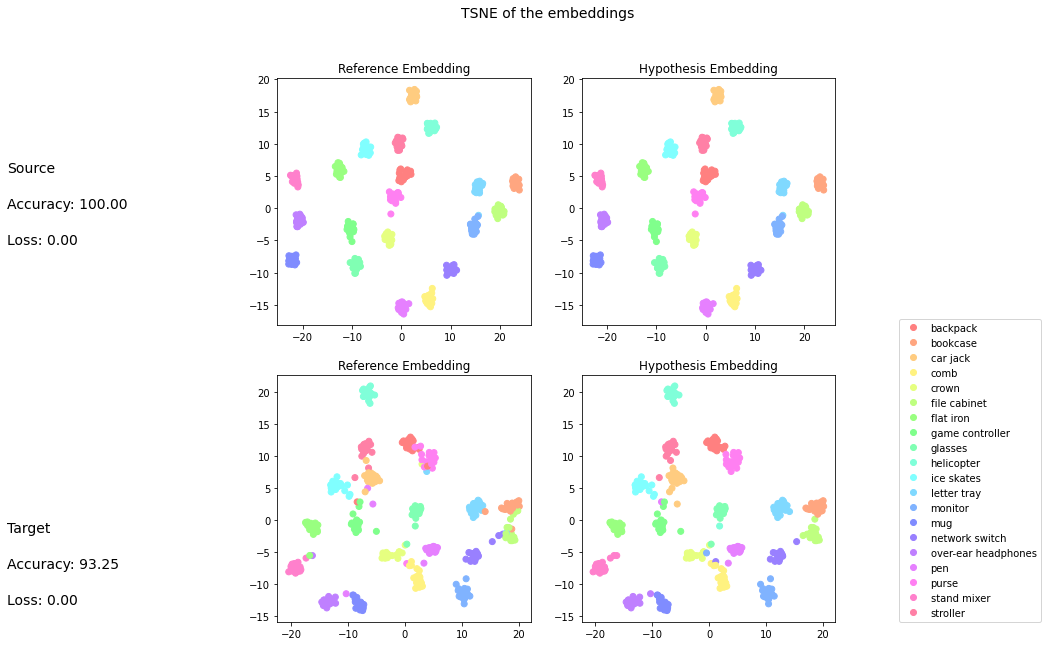

,precision,recall,f1-score,support
backpack,1.00,1.00,1.00,20.00
bookcase,1.00,1.00,1.00,20.00
car jack,1.00,1.00,1.00,20.00
comb,1.00,1.00,1.00,20.00
crown,1.00,1.00,1.00,20.00
file cabinet,1.00,1.00,1.00,20.00
flat iron,1.00,1.00,1.00,20.00
game controller,1.00,1.00,1.00,20.00
glasses,1.00,1.00,1.00,20.00
helicopter,1.00,1.00,1.00,20.00


(100.0, 93.25)

In [ ]:
extractor = Extractor(models.resnet18(weights=True),n_classes = N_CLASSES).to(device)
cost_function = get_ce_loss()
eval_plot_source_target(extractor,classifier,test_loader_r,test_loader_p,cost_function,class_mapping,layers=['fc1','fc2','fc3'],device='cuda:0')

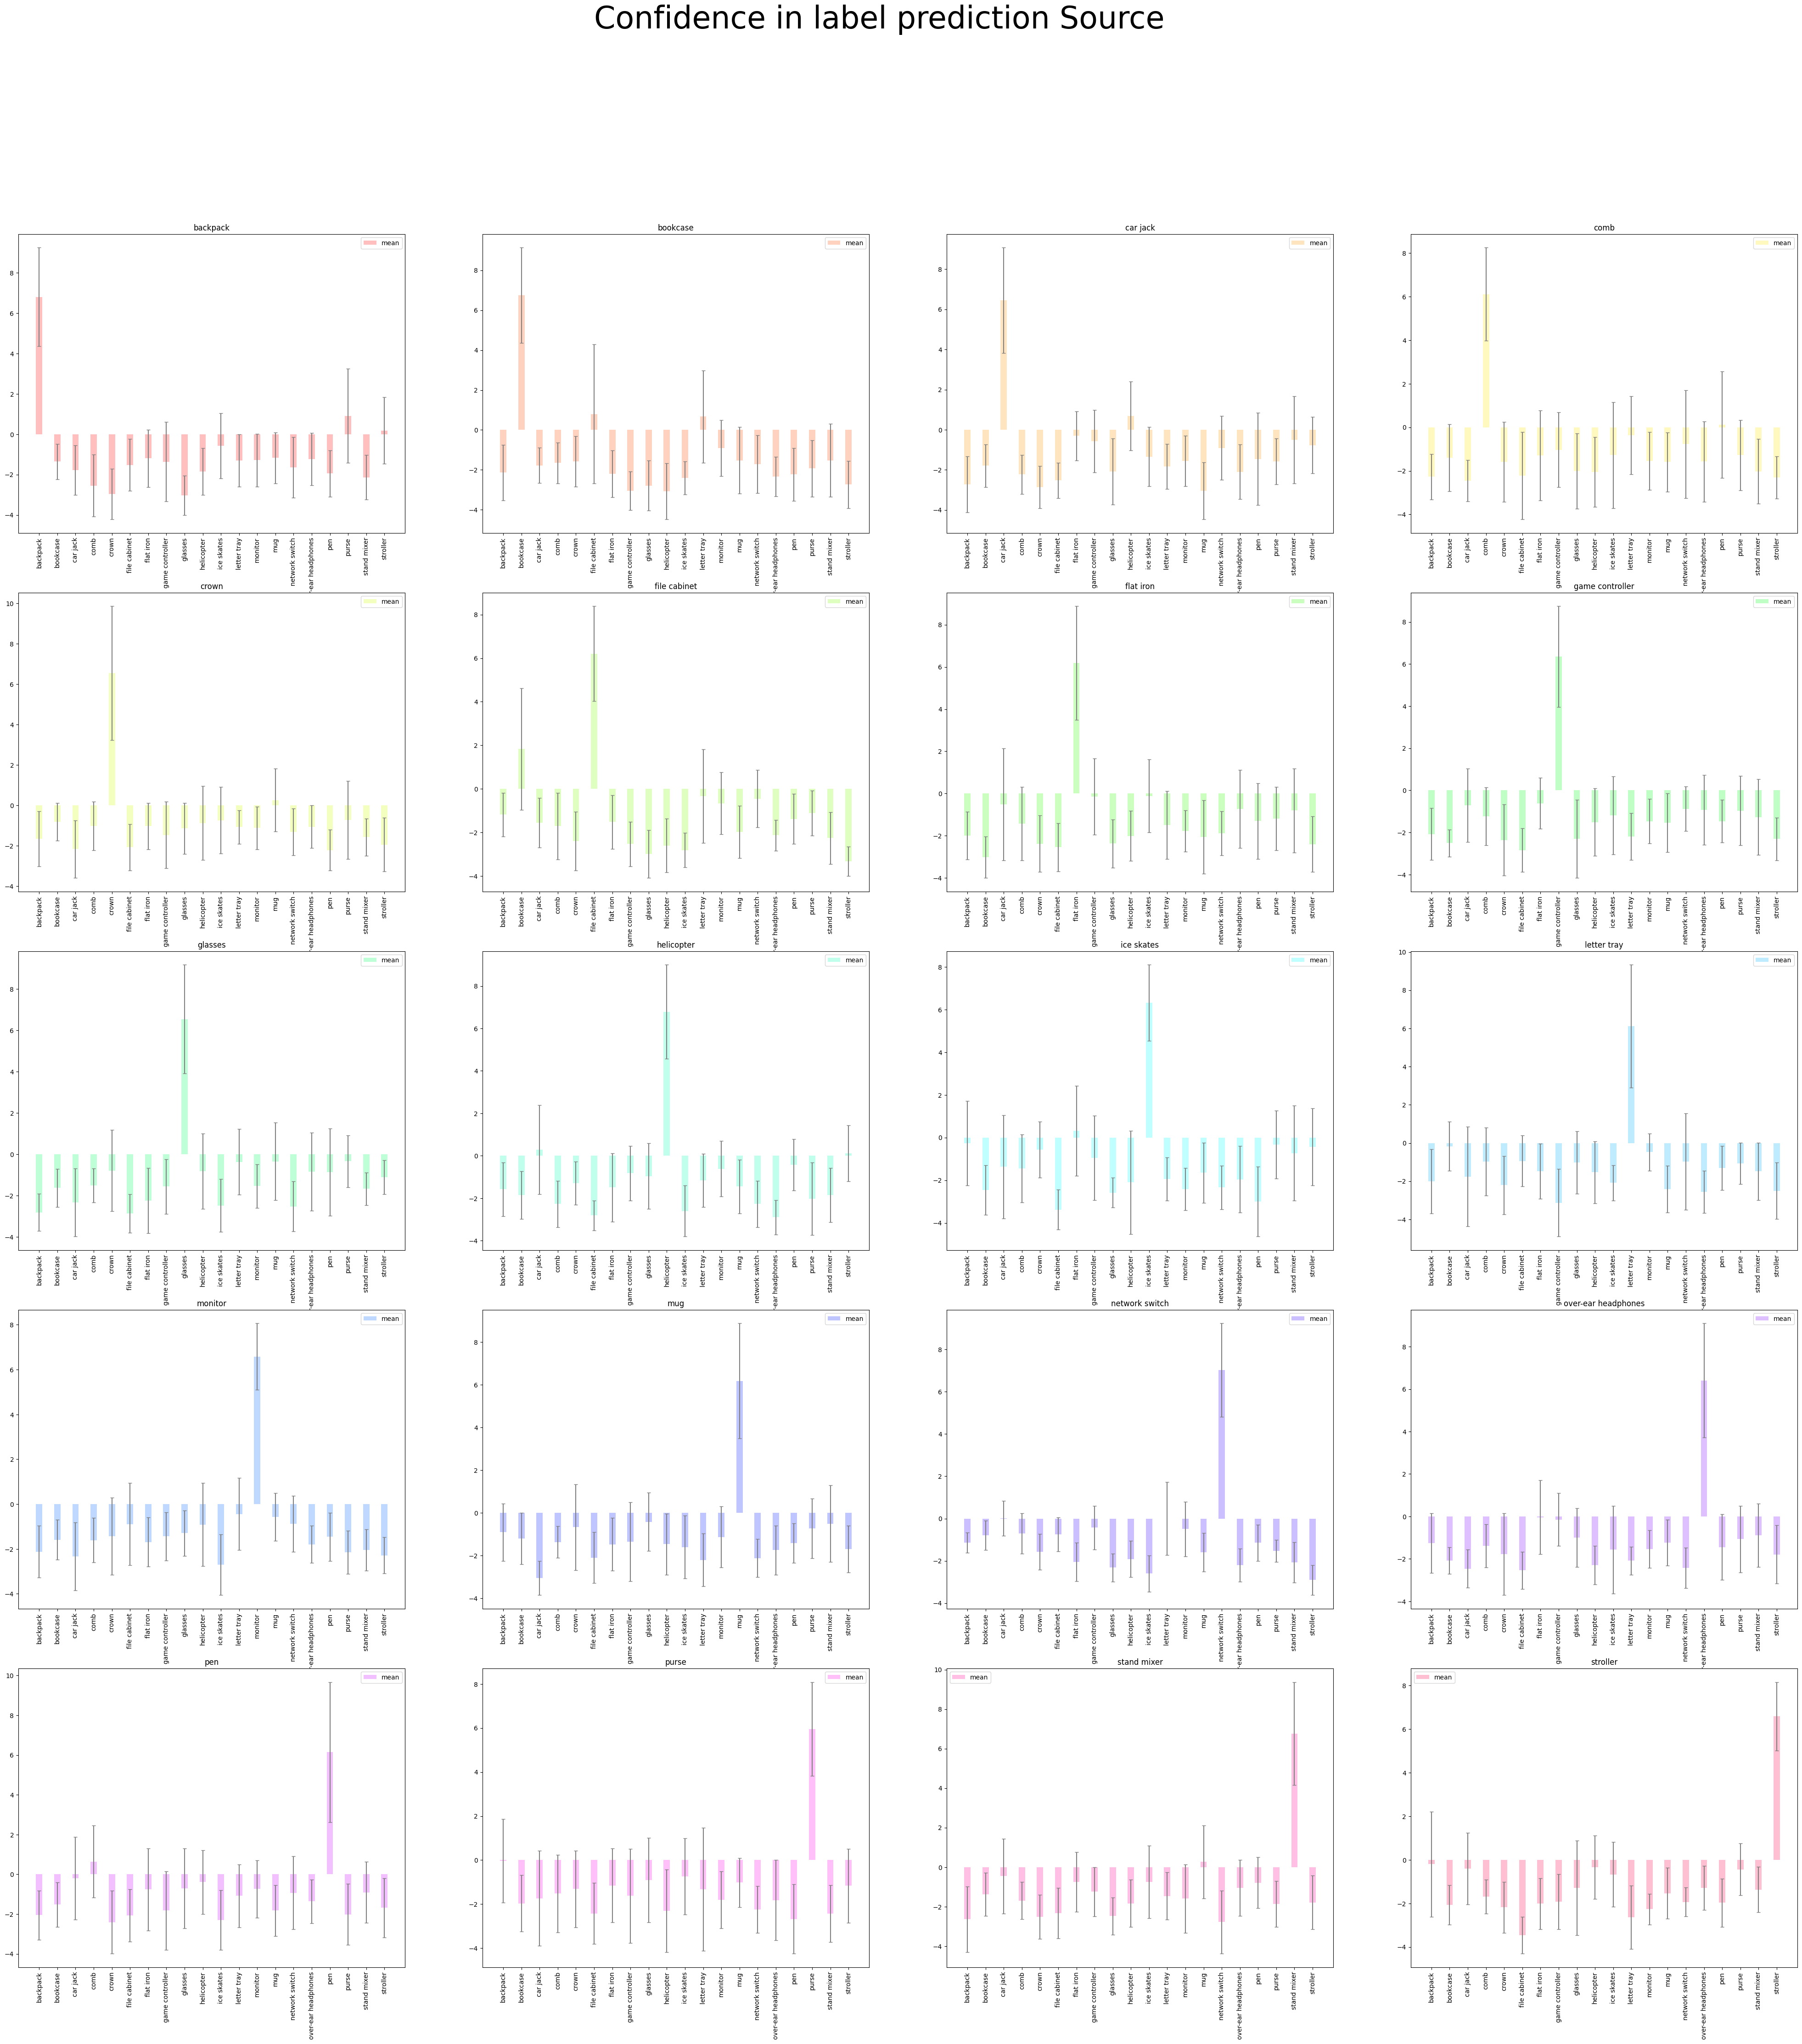

In [ ]:
prediction_confidence(net,test_loader_r,class_mapping,colormap,title='Confidence in label prediction Source',device='cuda:0')

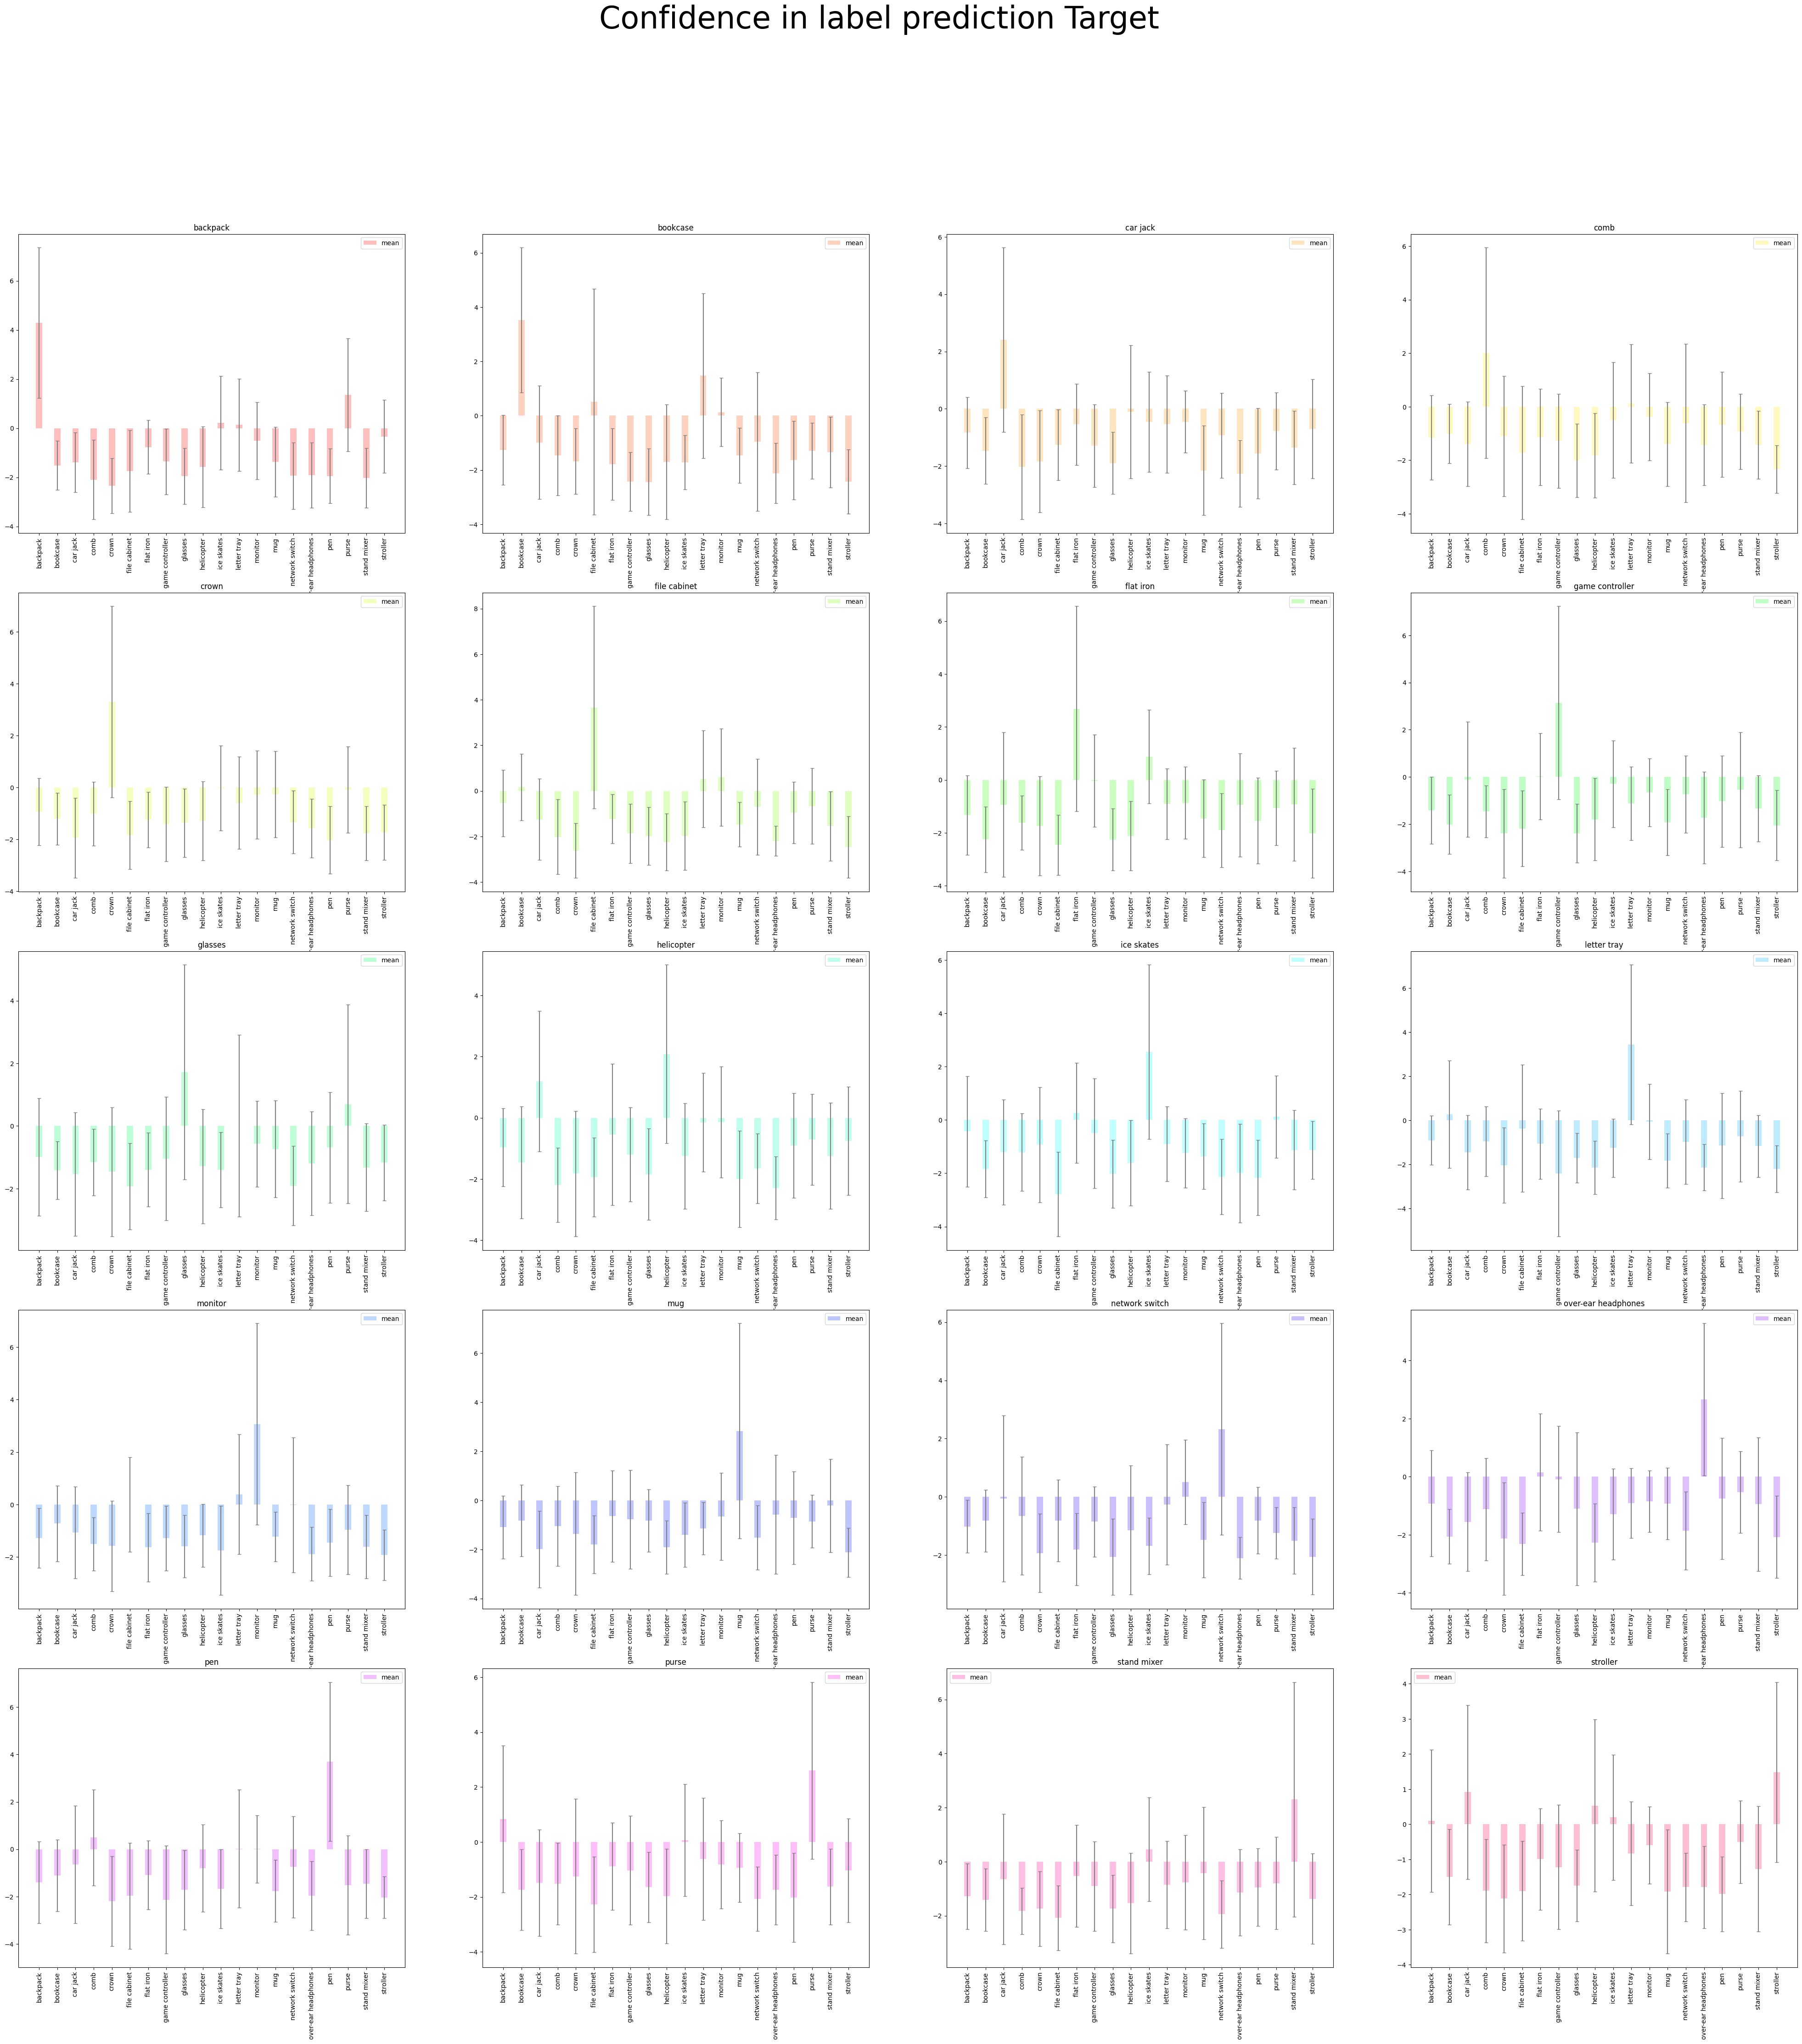

In [ ]:
prediction_confidence(net,test_loader_p,class_mapping,colormap,title='Confidence in label prediction Target',device='cuda:0')

### P -> R
`product_images` to `real_life`

#### Load

we load a pre computed model, useful to avoid retraining the model each time

In [ ]:
!cp "gdrive/MyDrive/"$resnet18_augmented_label_coral_p_r_path ./

In [ ]:
# load pre trained fine tuned model
%%capture
classifier = Classifier(512,n_classes = N_CLASSES, layers= ['fc1','fc2']).to(device)
classifier.load_state_dict(torch.load(resnet18_augmented_label_coral_p_r_path))
classifier.to(device)
classifier.eval()

#### Prune

In [ ]:
import torch.nn.utils.prune as prune

parameters_to_prune = (
    (classifier.fc1, 'weight'),
    (classifier.fc1, 'bias'),
    (classifier.fc2, 'weight'),
    (classifier.fc2, 'bias'),
    (classifier.fc3, 'weight'),
    (classifier.fc3, 'bias'),
    (classifier.fc4, 'weight'),
    (classifier.fc4, 'bias'),
)
prune.global_unstructured( parameters_to_prune, pruning_method=prune.L1Unstructured,amount=0.05)

#### Fine-tune

In [ ]:
extractor = Extractor(models.resnet18(weights=True),n_classes = N_CLASSES).to(device)
optimizer = get_optimizer(classifier,lr=0.0005, wd=0.000001)
ce_cost_function = get_ce_loss()
align_cost_function = get_label_coral_loss()
extractor,classifier = train(extractor,classifier,
            source_train_loader=train_loader_p,source_test_loader=test_loader_p,
            target_train_loader=train_loader_r,target_test_loader=test_loader_r, 
            ce_cost_function=ce_cost_function,align_cost_function=align_cost_function,
         optimizer = optimizer,
         epochs=5, 
         layers=['fc1','fc2','fc3'],
         align_loss_weight=100,
         device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

#### Test

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


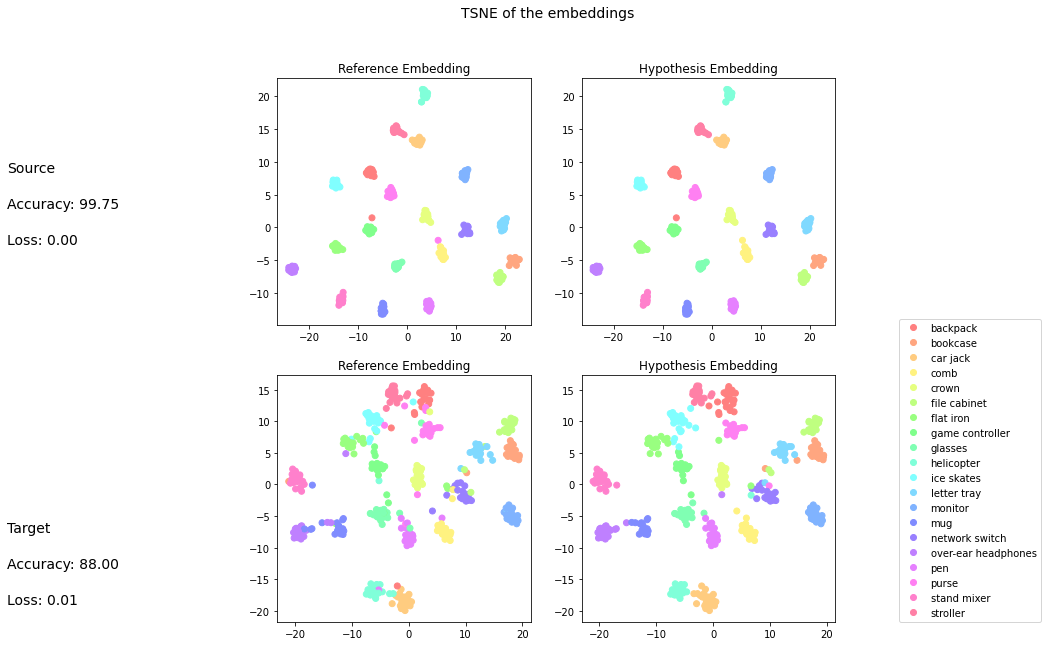

,precision,recall,f1-score,support
backpack,1.00,1.00,1.00,20.00
bookcase,1.00,1.00,1.00,20.00
car jack,1.00,1.00,1.00,20.00
comb,0.95,1.00,0.98,20.00
crown,1.00,1.00,1.00,20.00
file cabinet,1.00,1.00,1.00,20.00
flat iron,1.00,1.00,1.00,20.00
game controller,1.00,1.00,1.00,20.00
glasses,1.00,1.00,1.00,20.00
helicopter,1.00,1.00,1.00,20.00


(99.75, 88.0)

In [ ]:
extractor = Extractor(models.resnet18(weights=True),n_classes = N_CLASSES).to(device)
cost_function = get_ce_loss()
eval_plot_source_target(extractor,classifier,test_loader_p,test_loader_r,cost_function,class_mapping,layers=['fc1','fc2','fc3'],device='cuda:0')

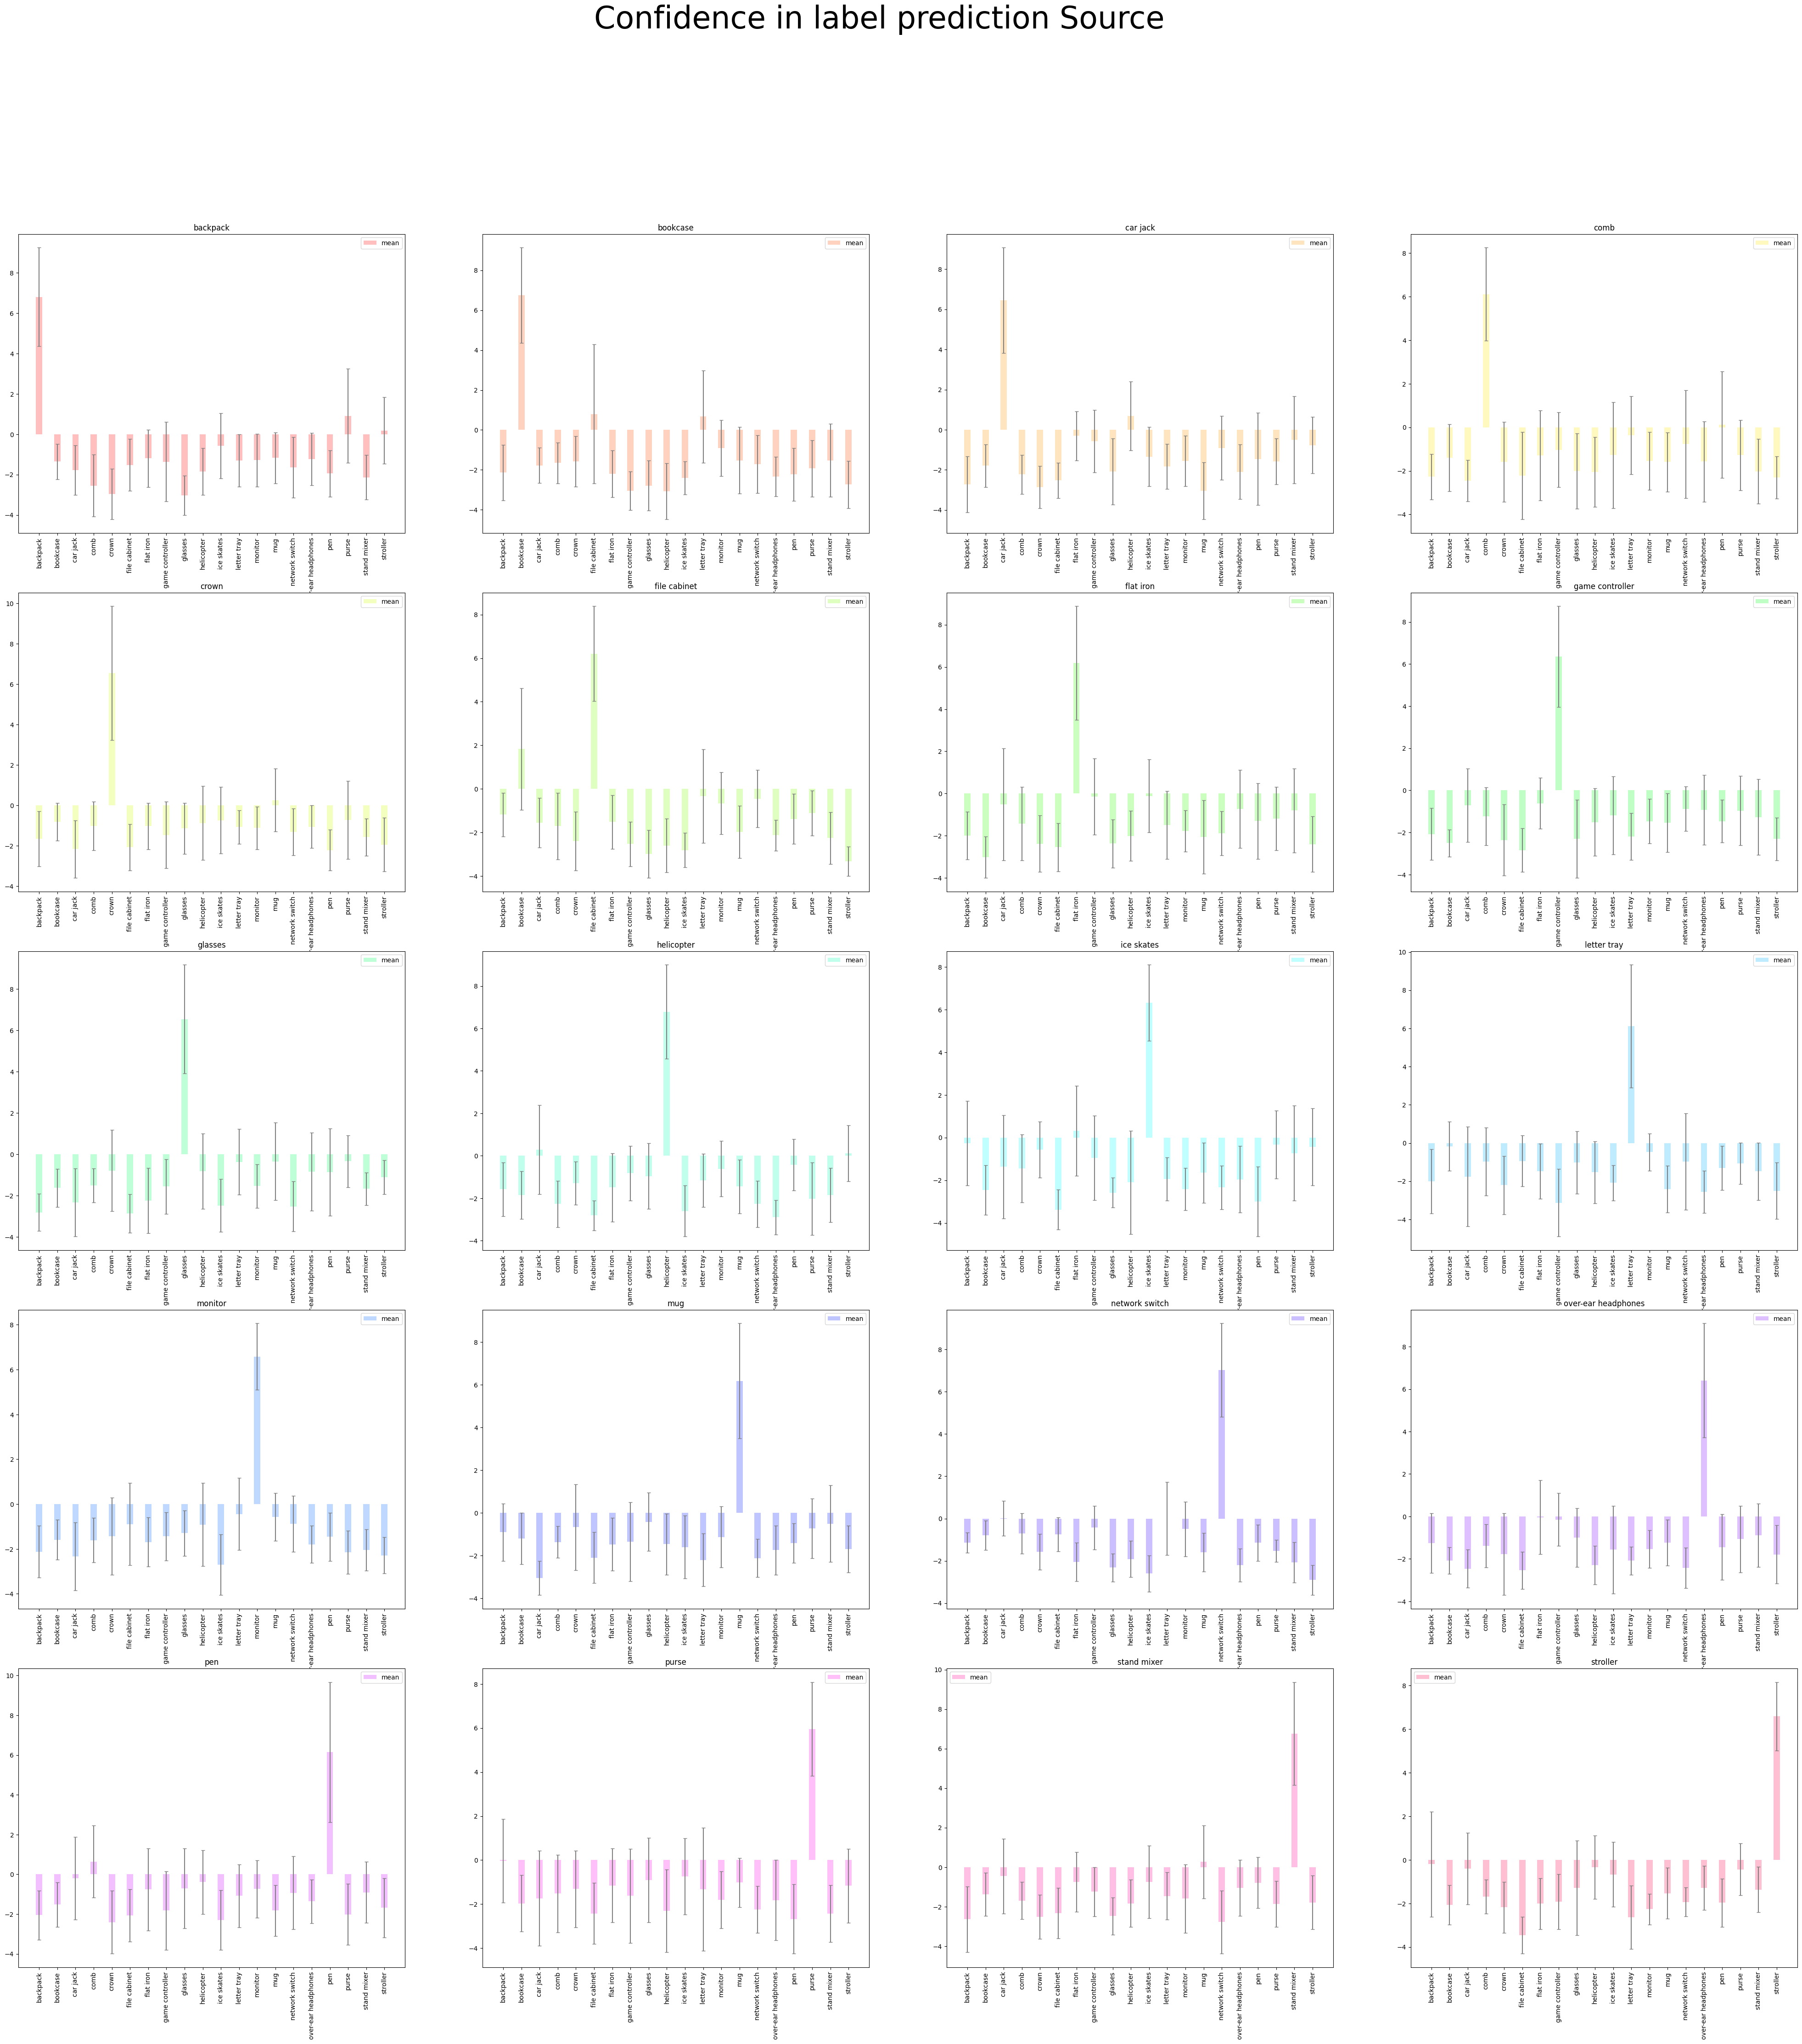

In [ ]:
prediction_confidence(net,test_loader_p,class_mapping,colormap,title='Confidence in label prediction Source',device='cuda:0')

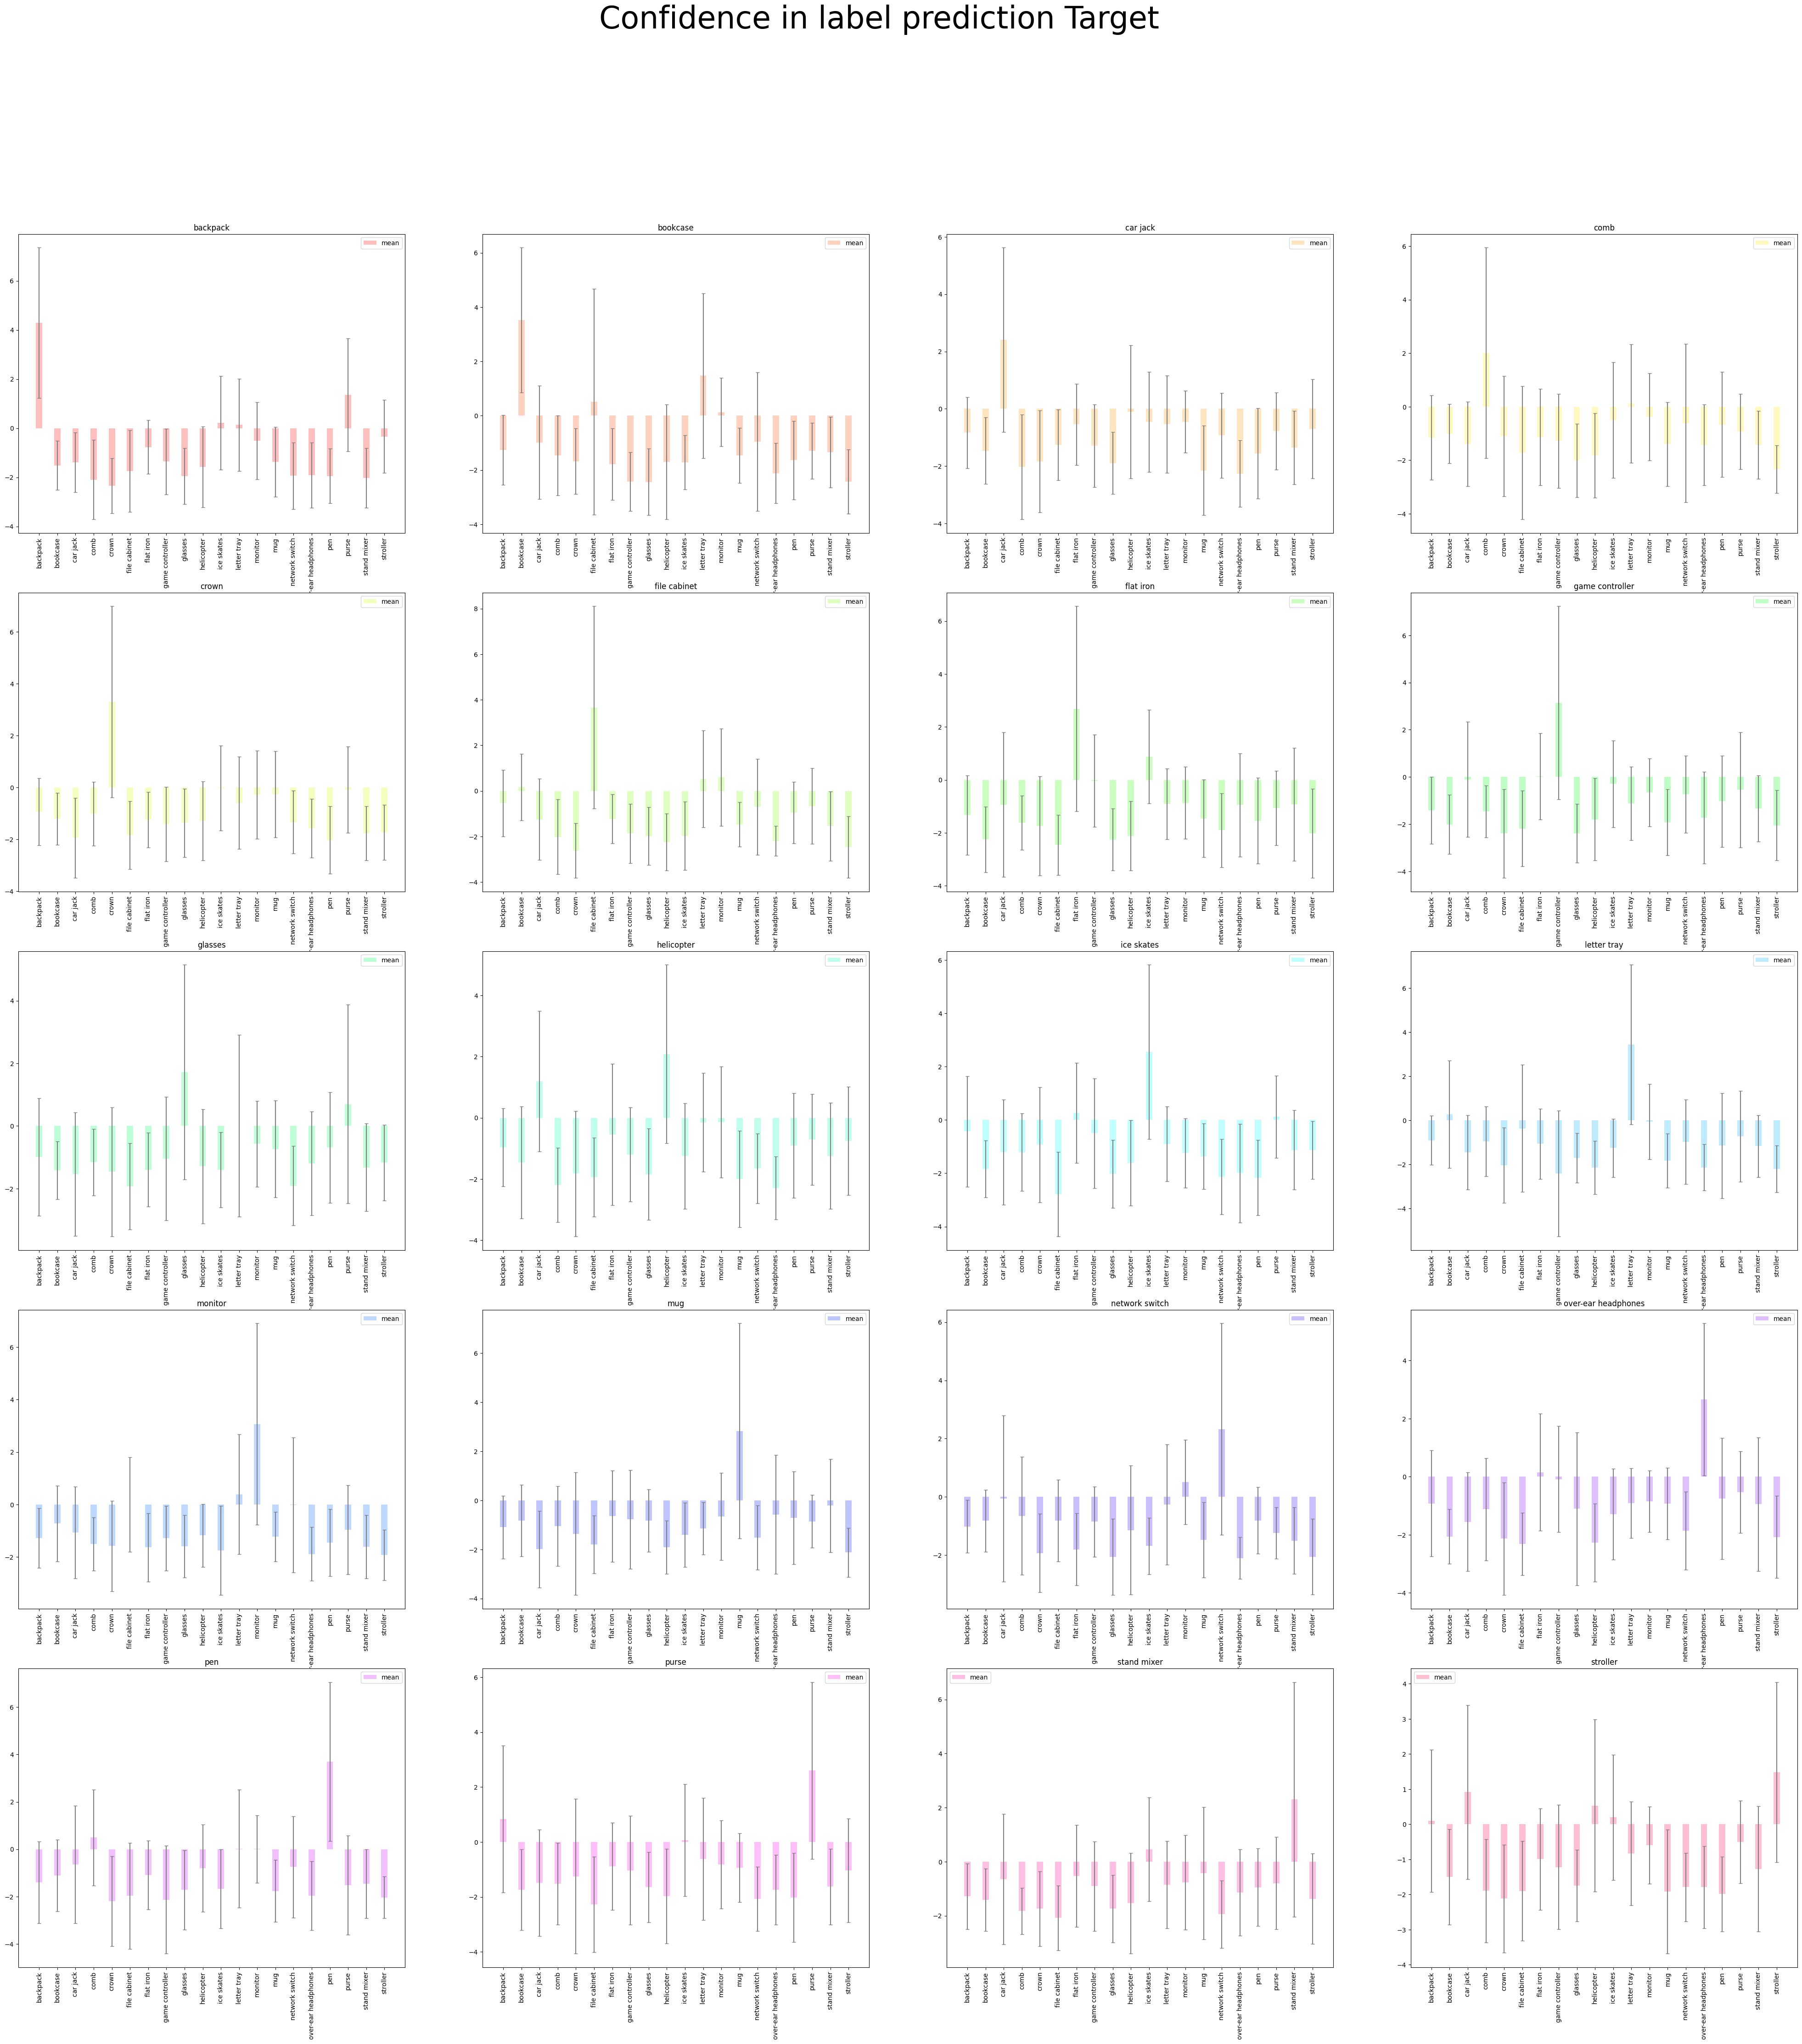

In [ ]:
prediction_confidence(net,test_loader_r,class_mapping,colormap,title='Confidence in label prediction Target',device='cuda:0')

### Comments

Very surprisingly the model does not perfom any better in either `real_life`or `product_images`

# Self Supervision and Distribution alignment

Here we test Self Supervision and Distribution alignment combined

TO DO, remove because memory requirements



## Model

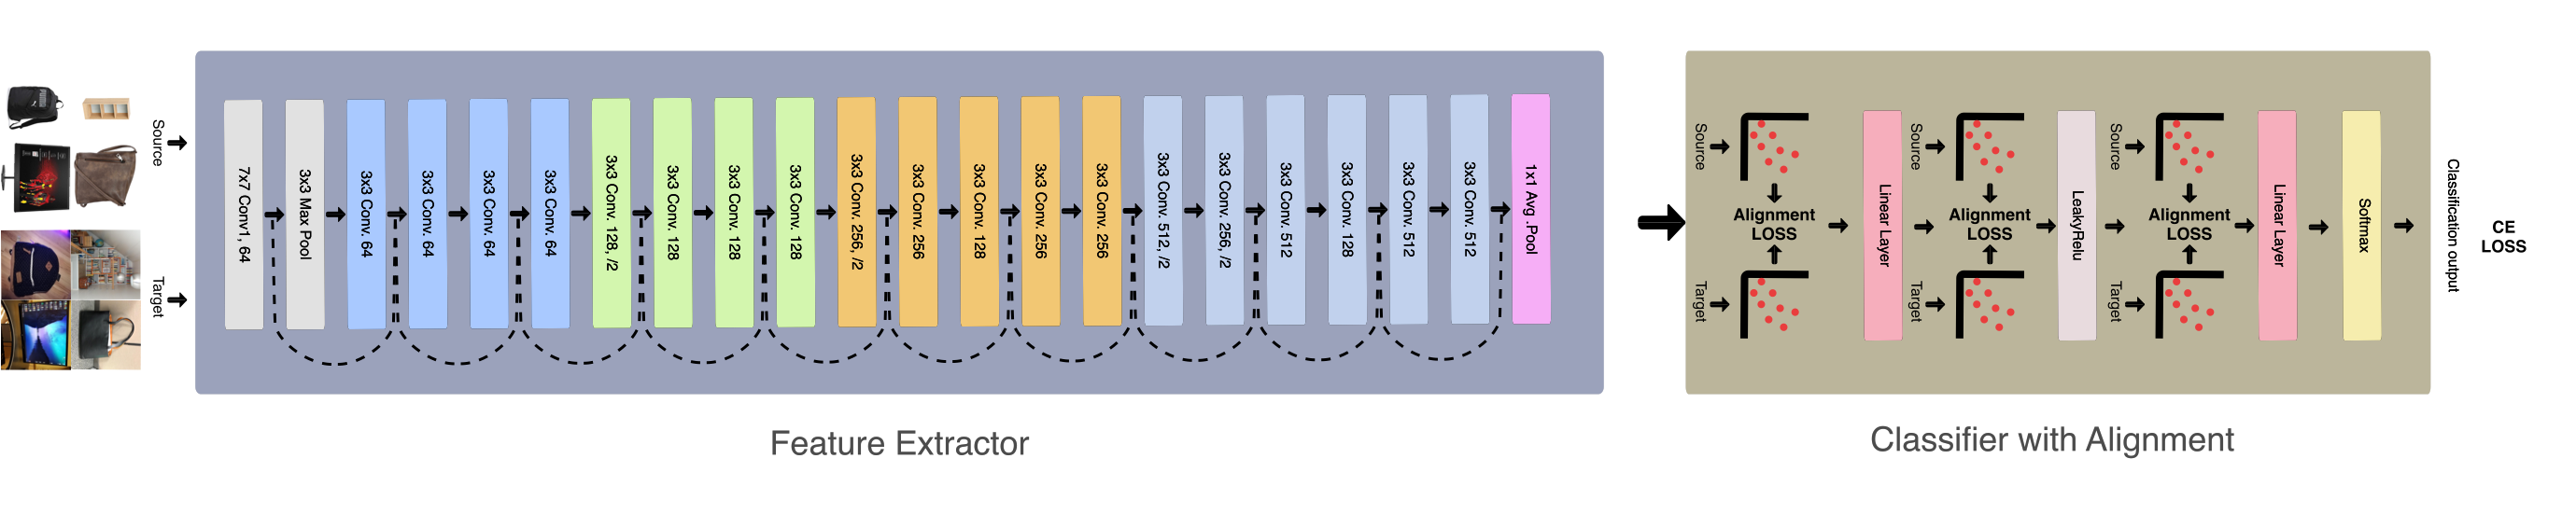

## Training step

In [ ]:
def training_step_ssuda_align(
    extractor: nn.Module,
    heads: List[nn.Module],
    optims: List[Any],
    criterions: List[nn.Module],
    align_cost_fun : nn.Module,
    source_data_loader: Iterable,
    target_data_loader: Iterable,
    layers: Iterable[str],
    align_loss_weight : int,

    device="cuda:0") -> Tuple[float, float]:

  samples = 0.
  cumulative_loss = 0.
  cumulative_align_loss = 0.
  cumulative_accuracy = 0.
  cumulative_rot_accuracy = 0.
  cumulative_flip_accuracy = 0.
  cumulative_patch_accuracy = 0.

  target_iter = iter(target_data_loader)
  
  extractor.train()
  for head in heads:
    head.train()
  
  pbar = tqdm(range(len(source_data_loader)),position=0, leave=False)
  for a, (batch_idx, (inputs_source, inputs_source_rotated, inputs_source_flipped, inputs_source_patch,
                      targets_source, targets_source_rotated, targets_source_flipped, targets_source_patch)) in zip(pbar, enumerate(source_data_loader)):
                      
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, inputs_target_rotated, inputs_target_flipped, inputs_target_patch, targets_target, targets_target_rotated, targets_target_flipped, targets_target_patch = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, inputs_target_rotated, inputs_target_flipped, inputs_target_patch, targets_target, targets_target_rotated, targets_target_flipped, targets_target_patch = next(target_iter)

    inputs_source = inputs_source.to(device)
    inputs_source_rotated = inputs_source_rotated.to(device)
    inputs_source_flipped = inputs_source_flipped.to(device)
    inputs_source_patch = inputs_source_patch.to(device)
    targets_source = targets_source.to(device)
    targets_source_rotated = targets_source_rotated.to(device)
    targets_source_flipped = targets_source_flipped.to(device)
    targets_source_patch = targets_source_patch.to(device)

    inputs_target = inputs_target.to(device)
    inputs_target_flipped = inputs_target_flipped.to(device)
    inputs_target_rotated = inputs_target_rotated.to(device)
    inputs_target_patch = inputs_target_patch.to(device)
    targets_target_rotated = targets_target_rotated.to(device)
    targets_target_flipped = targets_target_flipped.to(device)
    targets_target_patch = targets_target_patch.to(device)

    task_inputs_source = [inputs_source_rotated, inputs_source_flipped, inputs_source_patch]
    task_inputs_target = [inputs_target_rotated, inputs_target_flipped, inputs_target_patch]
    task_labels_source = [targets_source_rotated, targets_source_flipped, targets_source_patch]
    task_labels_target = [targets_target_rotated, targets_target_flipped, targets_target_patch]

    #  run self-supervised tasks
    task_outputs = []
    loss = 0.
    for task in range(1, 4):
      optims[task].zero_grad()
      inputs_concat = torch.cat((task_inputs_source[task-1], task_inputs_target[task-1]))
      labels_concat = torch.cat((task_labels_source[task-1], task_labels_target[task-1]))
      outputs = heads[task](extractor(inputs_concat))
      task_outputs.append(outputs)
      loss = criterions[task](outputs, labels_concat)
    loss.backward()
    for task in range(1, 4):
        optims[task].step()


    # now run supervised task
    optims[0].zero_grad()

    inputs = torch.cat((inputs_source, inputs_target))
    outputs,features = heads[0](extractor(inputs),layers)

    source_output, target_output = torch.split(outputs, 
                                                split_size_or_sections=outputs.shape[0] // 2, 
                                                dim=0)

    # run alignment
    align_loss = 0
    for feature in features:
        source_features, target_features = torch.split(feature, 
                                                split_size_or_sections=feature.shape[0] // 2, 
                                                dim=0)
        align_loss += align_cost_fun(source_features,target_features,source_labels=targets_source,target_labels=torch.argmax(target_output,dim=1),classes = source_features.shape[1],output_target_labels=target_output)
    
    cumulative_align_loss += align_loss

    ce_loss = criterions[0](source_output, targets_source)

    cumulative_loss += ce_loss
    loss = ce_loss + align_loss_weight * align_loss


    loss.backward()
    optims[0].step()

    samples += inputs_source.shape[0]
    _, predicted = source_output.max(dim = 1)
    cumulative_accuracy += predicted.eq(targets_source).sum().item()
      
    task_predicted = [out.max(dim=1) for out in task_outputs]
    _, predicted = task_predicted[0]
    targets_concat_rotated = torch.cat((targets_source_rotated, targets_target_rotated))
    cumulative_rot_accuracy += predicted.eq(targets_concat_rotated).sum().item()

    _, predicted = task_predicted[1]
    targets_concat_flipped = torch.cat((targets_source_flipped, targets_target_flipped))
    cumulative_flip_accuracy += predicted.eq(targets_concat_flipped).sum().item()
    
    _, predicted = task_predicted[2]
    targets_concat_patch = torch.cat((targets_source_patch, targets_target_patch))
    cumulative_patch_accuracy += predicted.eq(targets_concat_patch).sum().item()

  return (
      cumulative_loss/samples,float(cumulative_align_loss/samples), cumulative_accuracy/samples*100, cumulative_rot_accuracy/(samples*2)*100, 
      cumulative_flip_accuracy/(samples*2)*100, cumulative_patch_accuracy/(samples*2)*100)


In [ ]:
def train_ssuda_align(
    extractor: nn.Module,
    heads: List[nn.Module],
    optims: List[Any],
    criterions: List[nn.Module],
    align_cost_fun,
    source_train_loader_ss: Iterable,
    source_test_loader: Iterable,
    target_train_loader_ss: Iterable,
    target_test_loader: Iterable,
    epochs=50,
    layers: Iterable[str] = None,
    align_loss_weight=1,
    device='cuda:0') -> Tuple[nn.Module, nn.Module]:
  
    extractor.to(device)
    for head in heads:
      head.to(device)

    
    pbar = tqdm(range(epochs),position=0, leave=True)
    for p,e in zip(pbar,range(epochs)):
      
        train_loss, train_align_loss ,train_accuracy, rot_accuracy, flip_accuracy, patch_accuracy = training_step_ssuda_align(extractor, heads, optims, criterions, align_cost_fun,
                                                    source_train_loader_ss, target_train_loader_ss,layers,align_loss_weight) 

        test_source_loss, test_source_accuracy = test_step(extractor, heads[0], source_test_loader, 
                                            cost_function=criterions[0])

        test_target_loss, test_target_accuracy = test_step(extractor, heads[0], target_test_loader, 
                                            cost_function=criterions[0])
        pbar.set_description(str({
        'Training loss': f'{train_loss:.5f}',
        'Training align loss': f'{train_align_loss:.5f}',
        'Training accuracy': f'{train_accuracy:.5f}',
        'Training rotation accuracy': f'{rot_accuracy:.5f}',
        'Training flip accuracy': f'{flip_accuracy:.5f}',
        'Training patch accuracy': f'{patch_accuracy:.5f}',
        'Test Source loss': f'{test_source_loss:.5f}',
        'Test Source accuracy': f'{test_source_accuracy:.5f}',
        'Test Target loss': f'{test_target_loss:.5f}',
        'Test Target accuracy': f'{test_target_accuracy:.5f}',
        }))
    return extractor, heads

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input, n_classes: int, layers: Iterable[str] = None):
        super().__init__()
        self.identity = torch.nn.Identity()
        self.fc1 = torch.nn.Linear(in_features=input,out_features=input//4)
        self.relu = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(in_features=input//4,out_features=n_classes)
        self.layers = layers
        if layers != None:
            self._features = {layer: torch.empty(0) for layer in layers}
            for layer_id in layers:
                layer = dict([*self.named_modules()])[layer_id]
                layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor, layers: Iterable[str] = None) -> Tensor or Tuple[Tensor,Iterable[Tensor]]:
        out = x
        out = self.identity(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        if layers == None:
            return  out
        else:
            feature_list = []
            for i in layers:
                if self.layers != None and i in self.layers:
                    feature_list.append(self._features[i])
                if i not in self.layers:
                    raise NameError(f"{i} is not a valid layer or it was not stated in __init__")
            return out, feature_list

## LMMD

### Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product 

In [ ]:
extractor = Extractor(models.resnet18(weights=True))

# Tasks order:
# 0. classification (supervised)
# 1. rotation prediction (ss)
# 2. flip prediction (ss)
# 3. patch location prediction (ss) 
heads = []
heads.append(Classifier(input=512,n_classes=N_CLASSES,layers=['identity','fc1','relu']))
for _, out_classes in enumerate(task_classes[1:]):
  heads.append(Head(in_features=512, n_classes=out_classes))

optims = []
for idx, _ in enumerate(task_classes):
  optims.append(get_optimizer_ext_head([list(extractor.parameters()), list(heads[idx].parameters())],
                         lr=1e-4, wd=0.000001))
  
criterions = []
for idx, _ in enumerate(task_classes):
  criterions.append(nn.CrossEntropyLoss())

align_cost_function = get_lmmd_loss()

extractor, heads = train_ssuda_align(extractor, 
                                     heads, 
                                     optims, 
                                     criterions,
                                     align_cost_function, 
                                     train_loader_ss_r, 
                                     test_loader_r, 
                                     train_loader_ss_p, 
                                     test_loader_p, 
                                     epochs=50,
                                     layers=['identity','fc1','relu'],
                                     align_loss_weight=0.025)

In [ ]:
# save
torch.save(extractor.state_dict(), resnet18_ss_exta_r_p_path)
torch.save(heads[0].state_dict(), resnet18_ss_clfa_r_p_path)

In [ ]:
!cp $resnet18_ss_exta_r_p_path $models_basepath
!cp $resnet18_ss_clfa_r_p_path $models_basepath

#### Load

we load a pre computed model, useful to avoid retraining the model each time

In [ ]:
!cp $models_basepath$resnet18_ss_exta_r_p_path  ./
!cp $models_basepath$resnet18_ss_clfa_r_p_path  ./

In [ ]:
# load
%%capture
extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ss_exta_r_p_path))
extractor.to(device)
extractor.eval()
classifier = Head(extractor.model[-2][1].bn2.num_features,
                        n_classes=N_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_ss_clfa_r_p_path))
classifier.to(device)
classifier.eval()

####Test

Here we test the model and plot the TSNE embeddings of the features present in the last layer of the model (`avgpool`)

In [ ]:
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors = eval_plot_source_target(extractor,
                                                                                                                            classifier,
                                                                                                                            test_loader_r,
                                                                                                                            test_loader_p,
                                                                                                                            cost_function,
                                                                                                                            class_mapping,
                                                                                                                            layers=['identity','fc1','relu'],
                                                                                                                            device='cuda:0')

In [ ]:
confusion_matrix_plotter(matrix_source,matrix_target,class_mapping)

In [ ]:
show_error_images(test_loader_r,*source_errors,class_mapping,max_images=3)

In [ ]:
show_error_images(test_loader_p,*target_errors,class_mapping,max_images=3)

In [ ]:
prediction_confidence(net,test_loader_r,class_mapping,colormap,title='Confidence in label prediction Source',device='cuda:0')

In [ ]:
prediction_confidence(net,test_loader_p,class_mapping,colormap,title='Confidence in label prediction Target',device='cuda:0')

### Finetune ResNet18 on P -> R

In [ ]:
extractor = Extractor(models.resnet18(weights=True))

# Tasks order:
# 0. classification (supervised)
# 1. rotation prediction (ss)
# 2. flip prediction (ss)
# 3. patch location prediction (ss) 
heads = []
#heads.append(Head(in_features=512,n_classes=N_CLASSES,layers=['identity','fc1','relu']))
heads.append(Classifier(input=512,n_classes=N_CLASSES,layers=['identity','fc1','relu']))
for _, out_classes in enumerate(task_classes[1:]):
  #heads.append(Classifier(input=512, n_classes=out_classes))
  heads.append(Head(in_features=512, n_classes=out_classes))

optims = []
for idx, _ in enumerate(task_classes):
  optims.append(get_optimizer_ext_head([list(extractor.parameters()), list(heads[idx].parameters())],
                         lr=0.0005, wd=0.000001))
  
criterions = []
for idx, _ in enumerate(task_classes):
  criterions.append(nn.CrossEntropyLoss())

align_cost_function = get_lmmd_loss() 
extractor, heads = train_ssuda_align(extractor, 
                                     heads, 
                                     optims, 
                                     criterions,
                                     align_cost_function, 
                                     train_loader_ss_p, 
                                     test_loader_p, 
                                     train_loader_ss_r, 
                                     test_loader_r, 
                                     epochs=50,
                                     layers=['identity','fc1','relu'],
                                     align_loss_weight=0.1)

In [ ]:
# save
torch.save(extractor.state_dict(), resnet18_ss_exta_p_r_path)
torch.save(heads[0].state_dict(), resnet18_ss_clfa_p_r_path)

In [ ]:
!cp $resnet18_ss_exta_p_r_path $models_basepath
!cp $resnet18_ss_clfa_p_r_path $models_basepath

#### Load

we load a pre computed model, useful to avoid retraining the model each time

In [ ]:
!cp $models_basepath$resnet18_ss_exta_p_r_path  ./
!cp $models_basepath$resnet18_ss_clfa_p_r_path  ./

In [ ]:
# load
%%capture
extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ss_exta_p_r_path))
extractor.to(device)
extractor.eval()
classifier = Head(extractor.model[-2][1].bn2.num_features,
                        n_classes=N_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_ss_clfa_p_r_path))
classifier.to(device)
classifier.eval()

####Test

Here we test the model and plot the TSNE embeddings of the features present in the last layer of the model (`avgpool`). We also plot the confusion matrixes and the images that the model classifies incorrectly. Ultimately we plot the mean confidence in prediction for each class.

In [ ]:
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors  = eval_plot_source_target(extractor,
                                                                                                                             classifier,
                                                                                                                             test_loader_p,
                                                                                                                             test_loader_r,
                                                                                                                             cost_function,
                                                                                                                             class_mapping,
                                                                                                                             layers=['identity','fc1','relu'],
                                                                                                                             device='cuda:0')

In [ ]:
confusion_matrix_plotter(matrix_source,matrix_target,class_mapping)

In [ ]:
show_error_images(test_loader_p,*source_errors,class_mapping,max_images=3)

In [ ]:
show_error_images(test_loader_r,*target_errors,class_mapping,max_images=3)

In [ ]:
prediction_confidence(net,test_loader_p,class_mapping,colormap,title='Confidence in label prediction Source',device='cuda:0')

In [ ]:
prediction_confidence(net,test_loader_r,class_mapping,colormap,title='Confidence in label prediction Target',device='cuda:0')

In [ ]:
prediction_confidence(extractor,classifier,test_loader_p,class_mapping,colormap,title='Confidence in label prediction Target',device='cuda:0')

### Comments


The model does perform better with some specific domain adaptation layers where to compute the loss.

However the model is unable to get better target results in the direction from to `product_images` to `real_world` because the source results are also very limited. Because the model is not able to perform perfectly on source, target results are also affected. 

In the opposite direction from `real_world` to `product_images`, the model performs very well, achieving 100% in relative gain or 3.00 in absolute gain, saturating the model. 

Also, with more layers, the network may be more vulnerable to overfitting, but in our testing we did not have this issue. However we also tried to increase the number of layers, but that gave us worse results than fewer layers overall.
